In [194]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, GRU, SimpleRNN
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE

import joblib
import logging
import time
from pathlib import Path


logging.basicConfig(level=logging.DEBUG)
logger = logging.getLogger(__name__)
sns.set_style('darkgrid')

In [226]:
data_folder = Path('../data')
df = pd.read_csv(data_folder / 'internet_service_churn.csv')
df

,id,is_tv_subscriber,is_movie_package_subscriber,subscription_age,bill_avg,reamining_contract,service_failure_count,download_avg,upload_avg,download_over_limit,churn
0,15,1,0,11.95,25,0.14,0,8.4,2.3,0,0
1,18,0,0,8.22,0,NaN,0,0.0,0.0,0,1
2,23,1,0,8.91,16,0.00,0,13.7,0.9,0,1
3,27,0,0,6.87,21,NaN,1,0.0,0.0,0,1
4,34,0,0,6.39,0,NaN,0,0.0,0.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
72269,1689648,1,1,0.09,0,1.25,0,0.0,0.0,0,1
72270,1689676,1,0,0.06,1,1.63,0,0.8,0.0,0,1
72271,1689679,1,0,0.02,0,2.19,0,1.5,0.2,0,1
72272,1689733,0,0,0.01,0,0.72,0,0.0,0.0,0,1


Загальна інформація  по датасету

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72274 entries, 0 to 72273
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           72274 non-null  int64  
 1   is_tv_subscriber             72274 non-null  int64  
 2   is_movie_package_subscriber  72274 non-null  int64  
 3   subscription_age             72274 non-null  float64
 4   bill_avg                     72274 non-null  int64  
 5   reamining_contract           50702 non-null  float64
 6   service_failure_count        72274 non-null  int64  
 7   download_avg                 71893 non-null  float64
 8   upload_avg                   71893 non-null  float64
 9   download_over_limit          72274 non-null  int64  
 10  churn                        72274 non-null  int64  
dtypes: float64(4), int64(7)
memory usage: 6.1 MB


Бачимо що в деякіх колонках відсутні значення.  
5 ствбчик, що означає час до закінчення контракту та 7 і 8 стовбчики  - містить NaN значення.

Подивимось на іх кількість

In [33]:
df.isna().sum()

id                                 0
is_tv_subscriber                   0
is_movie_package_subscriber        0
subscription_age                   0
bill_avg                           0
reamining_contract             21572
service_failure_count              0
download_avg                     381
upload_avg                       381
download_over_limit                0
churn                              0
dtype: int64

Значення NaN в 5 стовбчику означає, що клієнт не укладав контракту з компанією.  
Додамо новий стовбчик 'contract', в якому позначимо - мав клієнт контракт (1) чи ні (0)

In [227]:
df['contract'] = df['reamining_contract'].apply(lambda x: 0 if pd.isna(x) else 1)
df.insert(5, 'contract', df.pop('contract'))
df['reamining_contract'] = df['reamining_contract'].fillna(0)

Кількість значеннь NaN в стовбчиках 'download_avg' та 'upload_avg' становить менш ніж 0,5% від усіх значень.  
Видалимо  рядки з NaN значеннями - це не вплине суттєво на  загальні данні 

In [228]:
df.dropna(subset=['download_avg', 'upload_avg'], inplace=True, ignore_index=True)

Датасет виглядяє наступним чином:

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71893 entries, 0 to 71892
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           71893 non-null  int64  
 1   is_tv_subscriber             71893 non-null  int64  
 2   is_movie_package_subscriber  71893 non-null  int64  
 3   subscription_age             71893 non-null  float64
 4   bill_avg                     71893 non-null  int64  
 5   contract                     71893 non-null  int64  
 6   reamining_contract           71893 non-null  float64
 7   service_failure_count        71893 non-null  int64  
 8   download_avg                 71893 non-null  float64
 9   upload_avg                   71893 non-null  float64
 10  download_over_limit          71893 non-null  int64  
 11  churn                        71893 non-null  int64  
dtypes: float64(4), int64(8)
memory usage: 6.6 MB


Перевіримо данні на наявність дублікатів

In [43]:
df[df.duplicated()]

,id,is_tv_subscriber,is_movie_package_subscriber,subscription_age,bill_avg,contract,reamining_contract,service_failure_count,download_avg,upload_avg,download_over_limit,churn


Подивимось на статистичні данні

In [44]:
df.iloc[:, 1:].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
is_tv_subscriber,71893.0,0.815225,0.388117,0.00,1.00,1.00,1.00,1.00
is_movie_package_subscriber,71893.0,0.334066,0.471666,0.00,0.00,0.00,1.00,1.00
subscription_age,71893.0,2.455486,2.026856,-0.02,0.94,1.98,3.30,12.80
bill_avg,71893.0,19.016844,13.188541,0.00,13.00,19.00,22.00,406.00
contract,71893.0,0.700694,0.457957,0.00,0.00,1.00,1.00,1.00
reamining_contract,71893.0,0.497612,0.665755,0.00,0.00,0.00,1.03,2.92
service_failure_count,71893.0,0.275674,0.818533,0.00,0.00,0.00,0.00,19.00
download_avg,71893.0,43.689911,63.405963,0.00,6.70,27.80,60.50,4415.20
upload_avg,71893.0,4.192076,9.818896,0.00,0.50,2.10,4.80,453.30
download_over_limit,71893.0,0.208713,0.999647,0.00,0.00,0.00,0.00,7.00


Данні портібно буде стандартизовувати оскільки присутня розбіжніжсь числових значень

----

Розділемо датасет на 2 частини:  
* одна для фінального тстування - 500 рядків 
* з іншої виділимо ознаки(features) та цільову ознаку(target)

In [229]:
df_final_test = df[:500]
df_final_test.to_csv(data_folder / 'test_internet_service_churn.csv', index=False)
df = df[500:]
y = df['churn']
X = df.drop(columns=['churn','id'])

Подивимось на збалансованість данних

In [46]:
print(y.value_counts())

churn
1    39669
0    31724
Name: count, dtype: int64


Розділемо данні на тренувальну та тестову вибірки.  
Враховуючи що є незбалансованість вирішено примінити oversample метод  SMOTE(Synthetic Minority Oversampling Technique)  
Для стандартизації данних будемо використовувати метод StandardScaler

In [140]:
oversample = SMOTE()
scaler = StandardScaler()

X_oversampled, y_oversampled = oversample.fit_resample(X, y)
X_scaled_oversampled = scaler.fit_transform(X_oversampled)

print(np.unique(y_oversampled, return_counts=True))

X_train, X_test, y_train, y_test = train_test_split(X_scaled_oversampled, y_oversampled, test_size=0.25, random_state=42, stratify=y_oversampled)
print('train X', X_train.shape)
print('train y', y_train.shape)
print('test X', X_test.shape)
print('test y', y_test.shape)


(array([0, 1], dtype=int64), array([39669, 39669], dtype=int64))
train X (59503, 10)
train y (59503,)
test X (19835, 10)
test y (19835,)


Бачимо що тепер кількість данних для обох класів однакова

Збережемо SCALER в файл для можливості подальшого використання

In [213]:
joblib.dump(scaler,'../models/scaler_Serhii.pkl')

['../models/scaler_Serhii.pkl']

----

## Побудова моделей

Підбирати найкращі гіперпараметри будемо за допомогою GridSearchCV

### Logistic regression

In [ ]:
lr_start_time = time.time()

LR = LogisticRegression(random_state=42)
param_grid = {'penalty':[None, 'l1', 'l2'],
              'C': [0.01, 0.001], 
              'max_iter':[20, 25, 30], 
              'solver': ['lbfgs', 'liblinear']
              }

logisticRegression = GridSearchCV(LR, param_grid, cv=3, refit=True, return_train_score=True, n_jobs=1)
logisticRegression.fit(X_train, y_train)
print(f'Logistic Regression best parameters: {logisticRegression.best_params_}')

lr_model = logisticRegression.best_estimator_
# lr_model.fit(X_train, y_train)

y_pred_lr = lr_model.predict(X_test)

lr_end_time = time.time()-lr_start_time
print(f'Build Logistic Regression model time: {lr_end_time:.2f} secs')

In [173]:
print(f'Logistic Regression best parameters: {logisticRegression.best_params_}')

Logistic Regression best parameters: {'C': 0.001, 'max_iter': 20, 'penalty': 'l2', 'solver': 'lbfgs'}


Статистика роботи моделі LogisticRegression на тестувальних данних 

Accuracy of SVC : 0.8822283841693975

 --------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.89      0.87      0.88      9918
           1       0.87      0.90      0.88      9917

    accuracy                           0.88     19835
   macro avg       0.88      0.88      0.88     19835
weighted avg       0.88      0.88      0.88     19835


 --------------------------------------------------


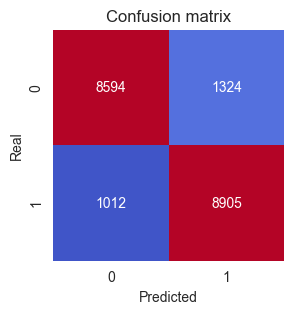

In [172]:
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print(f"Accuracy of SVC : {accuracy_lr}")
print('\n','-'*50)
print('Classification report:')
print(classification_report(y_test, y_pred_lr))
print('\n','-'*50)
cm = confusion_matrix(y_test, y_pred_lr)

plt.figure(figsize=(3, 3))
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=False, cmap='coolwarm', vmin=900, vmax=6000)
plt.title('Confusion matrix')
plt.ylabel('Real')
plt.xlabel('Predicted');

### LinearSVC

In [159]:
SVC = LinearSVC(random_state=42)

svc_start_time = time.time()
param_grid = {'C': [0.01, 0.1, 1], 'tol':[1e-4, 1e-05], 'max_iter':[1000, 10000]}
linearSVC = GridSearchCV(SVC, param_grid, cv=3, return_train_score=True, n_jobs=1)

linearSVC.fit(X_train, y_train)
print(f'LinearSVC best parameters: {linearSVC.best_params_}')

svc_model = linearSVC.best_estimator_
y_pred_svc = svc_model.predict(X_test)

svc_end_time = time.time()-svc_start_time
print(f'Build LinearSVC model time: {svc_end_time:.2f} secs')

LinearSVC best parameters: {'C': 0.01, 'max_iter': 1000, 'tol': 0.0001}
Build LinearSVC model time: 4.29 secs


Статистика роботи моделі LinearSVC на тестувальних данних 

Accuracy of SVC : 0.8786488530375599

 --------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.90      0.85      0.88      9918
           1       0.86      0.90      0.88      9917

    accuracy                           0.88     19835
   macro avg       0.88      0.88      0.88     19835
weighted avg       0.88      0.88      0.88     19835


 --------------------------------------------------


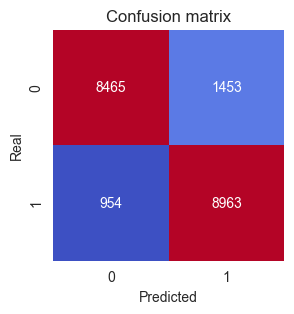

In [160]:
accuracy_svc = accuracy_score(y_test, y_pred_svc)
print(f"Accuracy of SVC : {accuracy_svc}")
print('\n','-'*50)
print('Classification report:')
print(classification_report(y_test, y_pred_svc))
print('\n','-'*50)
cm = confusion_matrix(y_test, y_pred_svc)

plt.figure(figsize=(3, 3))
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=False, cmap='coolwarm', vmin=900, vmax=6000)
plt.title('Confusion matrix')
plt.ylabel('Real')
plt.xlabel('Predicted');

Точність 88% не дуже гарний результат, але швидкість 6 секунд для всього процесу аналізу. Збережемо модель.

In [209]:
joblib.dump(svc_model,'../models/SVC_model_Serhii.pkl')

['../models/SVC_model_Serhii.pkl']

----

### RandomForest

In [174]:
RF = RandomForestClassifier(random_state=42)

rf_start_time = time.time()
param_grid = {'n_estimators': [50, 100, 200], 'max_features':['sqrt', 'log2']}
RandomForest = GridSearchCV(estimator=RF, param_grid=param_grid, scoring='f1', cv=2, return_train_score=True, n_jobs=1, verbose=3)

RandomForest.fit(X_train, y_train)
print(f'RandomForest best parameters: {RandomForest.best_params_}')

rf_model = RandomForest.best_estimator_
y_pred_rf = rf_model.predict(X_test)

rf_end_time = time.time()-rf_start_time
print(f'Build RandomForest model time: {rf_end_time:.2f} secs')

Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV 1/2] END max_features=sqrt, n_estimators=50;, score=(train=1.000, test=0.943) total time=   3.4s
[CV 2/2] END max_features=sqrt, n_estimators=50;, score=(train=1.000, test=0.942) total time=   2.9s
[CV 1/2] END max_features=sqrt, n_estimators=100;, score=(train=1.000, test=0.944) total time=   6.1s
[CV 2/2] END max_features=sqrt, n_estimators=100;, score=(train=1.000, test=0.942) total time=   5.8s
[CV 1/2] END max_features=sqrt, n_estimators=200;, score=(train=1.000, test=0.944) total time=  12.0s
[CV 2/2] END max_features=sqrt, n_estimators=200;, score=(train=1.000, test=0.942) total time=  12.9s
[CV 1/2] END max_features=log2, n_estimators=50;, score=(train=1.000, test=0.943) total time=   3.6s
[CV 2/2] END max_features=log2, n_estimators=50;, score=(train=1.000, test=0.942) total time=   3.7s
[CV 1/2] END max_features=log2, n_estimators=100;, score=(train=1.000, test=0.944) total time=   6.5s
[CV 2/2] END max_features=

Статистика роботи моделі на тестувальних данних

Accuracy of RF : 0.9453491303251828

 --------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.93      0.96      0.95      9918
           1       0.96      0.93      0.94      9917

    accuracy                           0.95     19835
   macro avg       0.95      0.95      0.95     19835
weighted avg       0.95      0.95      0.95     19835


 --------------------------------------------------


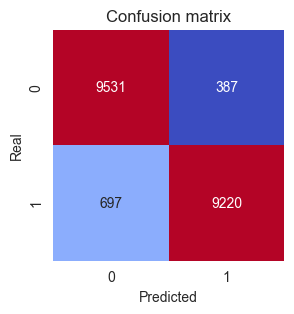

In [175]:
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy of RF : {accuracy_rf}")
print('\n','-'*50)
print('Classification report:')
print(classification_report(y_test, y_pred_rf))
print('\n','-'*50)
cm = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(3, 3))
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=False, cmap='coolwarm', vmin=600, vmax=1000)
plt.title('Confusion matrix')
plt.ylabel('Real')
plt.xlabel('Predicted');


Отримаємо чудовий результат майже 95% точності на тестувальній вибірці. Збережемо модель.

In [176]:
joblib.dump(rf_model,'../models/RF_model_Serhii.pkl', compress=3)

['../models/RF_model_Serhii.pkl']

Важливість ознак в датасеті для отриманої моделі

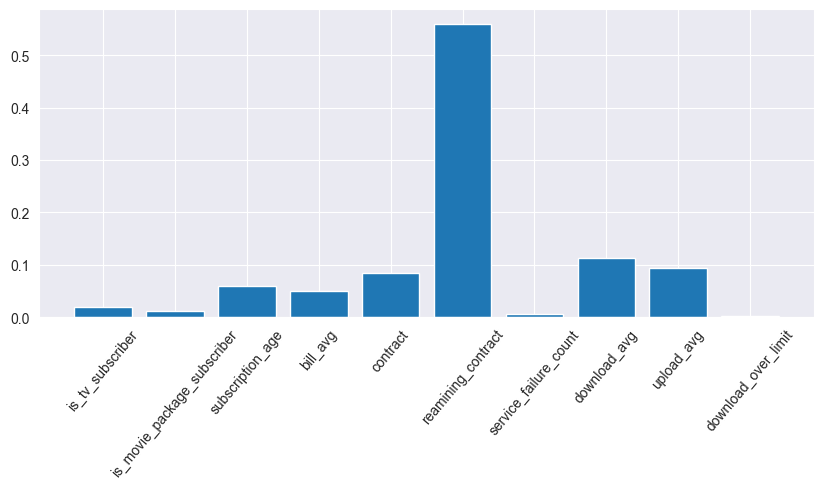

In [178]:
plt.figure(figsize=(10,4))
plt.bar(range(len(rf_model.feature_importances_)), rf_model.feature_importances_)
plt.xticks(range(len(df.columns[1:-1])), df.columns[1:-1], rotation=50);

----

### Basic Neural Network

Побудуємо просту нейронну мережу.  
Розмірність данних змінемо за допомогою MinMaxScaler

In [179]:
min_max_scaler = MinMaxScaler()
X_scaled = min_max_scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=42, stratify=y)

In [180]:
model_NN = Sequential()
model_NN.add(Dense(128, input_dim=10, activation='relu'))
model_NN.add(Dropout(0.2))
model_NN.add(Dense(64, activation='relu'))
model_NN.add(Dropout(0.2))
model_NN.add(Dense(1, activation='sigmoid'))

model_NN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_NN.summary()

nn_start_time = time.time()
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
history = model_NN.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.1, callbacks=[early_stopping])

score = model_NN.evaluate(X_test, y_test, verbose=0)

pred = model_NN.predict(X_test)

nn_end_time = time.time()-nn_start_time
print(f'Build NN model time: {nn_end_time:.2f} secs')

c:\Users\serge\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 128)            │         1,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,729 (38.00 KB)

 Trainable params: 9,729 (38.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
753/753 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8435 - loss: 0.3984 - val_accuracy: 0.8943 - val_loss: 0.2913
Epoch 2/20
753/753 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9065 - loss: 0.2748 - val_accuracy: 0.9089 - val_loss: 0.2654
Epoch 3/20
753/753 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9131 - loss: 0.2590 - val_accuracy: 0.9158 - val_loss: 0.2502
Epoch 4/20
753/753 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9196 - loss: 0.2454 - val_accuracy: 0.9163 - val_loss: 0.2451
Epoch 5/20
753/753 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9218 - loss: 0.2371 - val_accuracy: 0.9190 - val_loss: 0.2373
Epoch 6/20
753/753 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9251 - loss: 0.2308 - val_accuracy: 0.9199 - val_loss: 0.2363
Epoch 7/20
753/753 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9260 - loss: 0.2285 - val_accuracy: 0.9219 - val_loss: 0.2280
Epoch 8/20
753/753 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9252 - loss: 0.2269 - val_accuracy: 0.

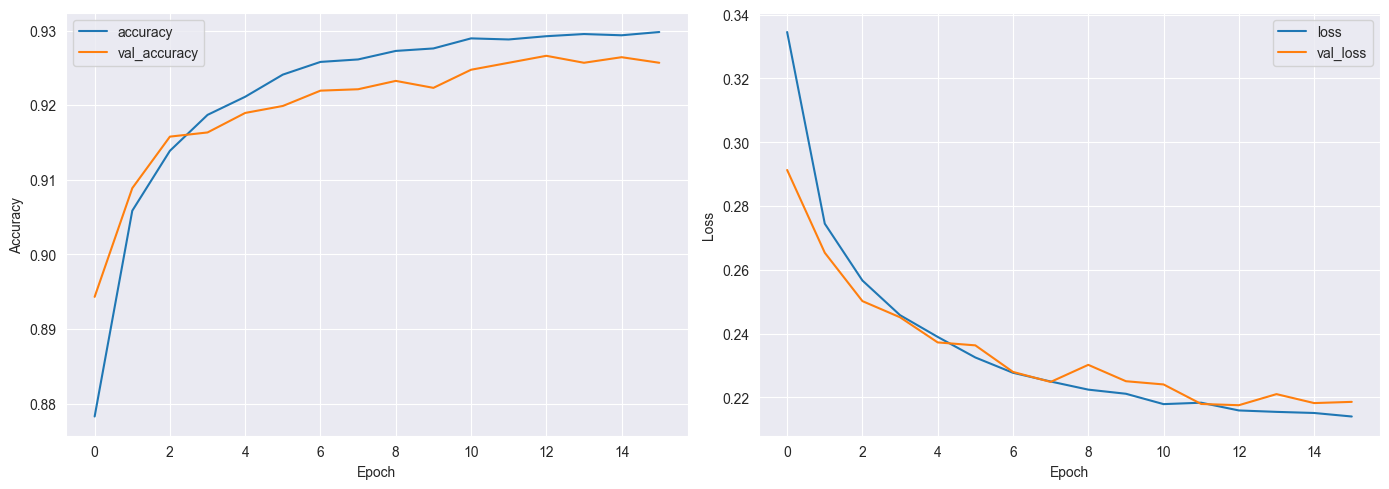

In [181]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Статистика роботи моделі на тестувальних данних

--------------------------------------------------
Test loss: 0.21083727478981018
Test accuracy: 0.9289596080780029
--------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.91      0.94      0.92      7931
           1       0.95      0.92      0.94      9918

    accuracy                           0.93     17849
   macro avg       0.93      0.93      0.93     17849
weighted avg       0.93      0.93      0.93     17849



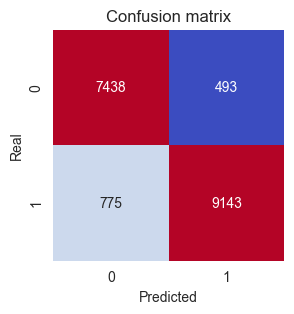

In [182]:
binary_predictions = [1 if p > 0.5 else 0 for p in pred]

print('-'*50)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print('-'*50)
print('Classification report:')
print(classification_report(y_test, binary_predictions))

cm = confusion_matrix(y_test, binary_predictions)

plt.figure(figsize=(3, 3))
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=False, cmap='coolwarm', vmin=600, vmax=1000)
plt.title('Confusion matrix')
plt.ylabel('Real')
plt.xlabel('Predicted');

Збережемо модель та скейлер

In [183]:
joblib.dump(model_NN,'../models/NN_model_Serhii.pkl')
joblib.dump(min_max_scaler,'../models/NN_scaler_Serhii.pkl')

['../models/NN_scaler_Serhii.pkl']

### Порівняємо роботу різних моделей

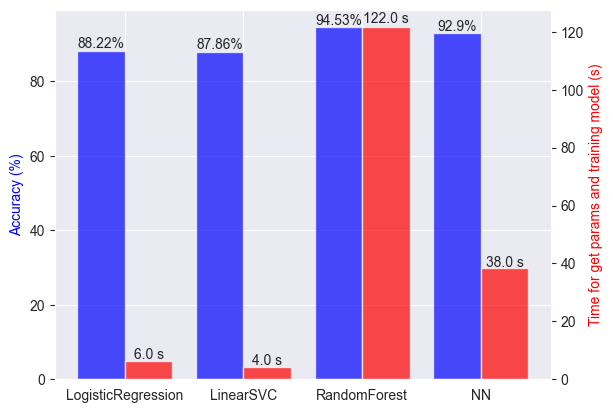

In [219]:
data = {'model':['LogisticRegression','LinearSVC', 'RandomForest', 'NN'],
        'analyze_time':[lr_end_time, svc_end_time, rf_end_time, nn_end_time],
        'accuracy':[accuracy_lr*100, accuracy_svc*100, accuracy_rf*100 ,score[1]*100]}

df_results = pd.DataFrame(data)

fig, ax= plt.subplots()
ax2 = ax.twinx()
width = 0.4

x = np.array([i for i,_ in enumerate(df_results['model'])])

ax.bar(x - width/2, df_results['accuracy'], color='b', alpha=0.7, width=width)
ax2.bar(x + width/2, df_results['analyze_time'], color='r', alpha=0.7, width=width)

plt.xticks(range(len(df_results['model'])), df_results['model'], rotation=0);
ax.set_ylabel('Accuracy (%)', color='b')
ax2.set_ylabel('Time for get params and training model (s)', color='r')

for i, v in enumerate(df_results['accuracy'].round(2)):
    ax.text(i-0.2, v, str(v)+'%', ha='center', va='bottom')

for i, v in enumerate(df_results['analyze_time'].round()):
    ax2.text(i+0.2, v, str(v)+' s', ha='center', va='bottom')

plt.grid()
plt.show()

Зробимо фінальне тестування

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


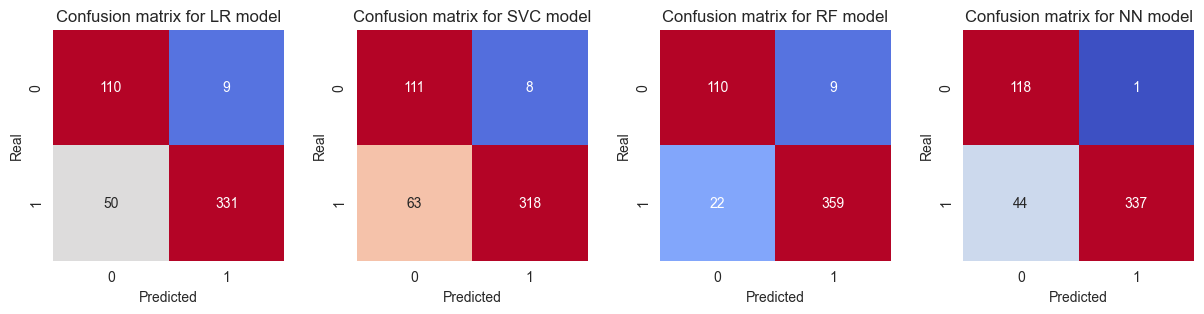

In [189]:
data = df_final_test.drop(columns=['churn'])
features = data.drop(columns=['id'])
target = df_final_test['churn']
ids = data['id']
y_pred_lr = lr_model.predict(scaler.transform(features))
y_pred_svc = svc_model.predict(scaler.transform(features))
y_pred_rf = rf_model.predict(scaler.transform(features))
y_pred_nn =[1 if p > 0.5 else 0 for p in model_NN.predict(min_max_scaler.transform(features))]

pred = {'LR':y_pred_lr, 'SVC':y_pred_svc, 'RF':y_pred_rf, 'NN':y_pred_nn}

plt.figure(figsize=(15, 3))
for i, (m, p) in enumerate(pred.items()):
    cm = confusion_matrix(target, p)
    plt.subplot(1, 4, i+1)
    sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=False, cmap='coolwarm', vmin=0, vmax=100)
    plt.title(f'Confusion matrix for {m} model')
    plt.ylabel('Real')
    plt.xlabel('Predicted');

Отримаємо ID клієнтов які скоіш за все припинять користуватись послугами

In [281]:
def get_potential_lose_customer(data, model):
    features = data.drop(columns=['id'])
    ids = data['id']
    pred = model.predict(features)
    if len(np.unique(pred)) > 2:
        pred = [1 if p > 0.5 else 0 for p in pred]
    customers = [ids[i] for i in range(len(ids)) if pred[i] == 1]
    return customers

In [285]:
result = get_potential_lose_customer(df_final_test.drop(columns=['churn']), model_NN)
for id in result:
    print(f'Client ID: {id}')

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 541us/step
Client ID: 18
Client ID: 23
Client ID: 27
Client ID: 34
Client ID: 71
Client ID: 84
Client ID: 94
Client ID: 112
Client ID: 166
Client ID: 213
Client ID: 222
Client ID: 270
Client ID: 291
Client ID: 417
Client ID: 475
Client ID: 530
Client ID: 550
Client ID: 608
Client ID: 642
Client ID: 644
Client ID: 680
Client ID: 682
Client ID: 683
Client ID: 730
Client ID: 734
Client ID: 831
Client ID: 848
Client ID: 905
Client ID: 921
Client ID: 928
Client ID: 933
Client ID: 945
Client ID: 999
Client ID: 1006
Client ID: 1038
Client ID: 1048
Client ID: 1051
Client ID: 1061
Client ID: 1201
Client ID: 1206
Client ID: 1226
Client ID: 1281
Client ID: 1296
Client ID: 1311
Client ID: 1327
Client ID: 1414
Client ID: 1416
Client ID: 1455
Client ID: 1457
Client ID: 1568
Client ID: 1664
Client ID: 1684
Client ID: 1693
Client ID: 1694
Client ID: 1709
Client ID: 1717
Client ID: 1733
Client ID: 1744
Client ID: 1746
Client ID: 1778
Client ID: 1844
Client ID: 1893
Client 